In [2]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy
from sklearn.model_selection import KFold


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [5]:
def norm(x, *par):
    return par[0]*np.exp(par[1]*x**2)

In [6]:
def poly(x, *par):
    return np.polyval(par,x)

In [7]:
def log(x, *par):
    return par[0]*np.log(x)

In [8]:
def const(x, *par):
    return -10

In [9]:
def recip(x, *par):
    return 1/(par[0]*x**2+1)

In [10]:
def gp(x_train, y_train, kernel, mean_function, init_params):
    res = scipy.optimize.curve_fit(
        mean_function,  np.ravel(x_train), np.ravel(y_train), p0=init_params, maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_function(x, *par)
    mf.update_gradients = lambda a,b: None
    
    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()
    return model

In [11]:
def draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, subplot, ylim=False):
    subplot.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    subplot.scatter(x_train, y_train, marker="x", color='black', label="train")
    subplot.scatter(x_val, y_val, marker="x", color='red', label="validate")
    subplot.scatter(x_test, y_test, marker="x", color='blue', label="test")
    subplot.plot(domain, y_mean, label="mean")
    if ylim:
        subplot.set_ylim(ylim)       
    subplot.grid(True)
    subplot.legend()


In [12]:
def cwgp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    model_holder = kwargs["model_holder"]
    
    cwgp_y_train = y_train
    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp_model in model_holder:
        cwgp_y_train, y_d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_train)
        
        cwgp_y_val, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_val)
        
        cwgp_y_test, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_test)
        
    model = gp(x_train, cwgp_y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )

    start, end = 1940, 2030
    domain_discrete = np.arange(start, end+1).reshape(-1,1)
    domain = np.linspace(start,end,end-start+1)
    cwgp_y_all = model.predict(domain_discrete)
    cwgp_y_mean, cwgp_y_var = cwgp_y_all[0], cwgp_y_all[1]
    cwgp_y_top, cwgp_y_bot = cwgp_y_mean + 1.96*np.sqrt(cwgp_y_var), cwgp_y_mean - 1.96*np.sqrt(cwgp_y_var)
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    
    y_mean, y_var, y_top, y_bot = cwgp_y_mean, cwgp_y_var, cwgp_y_top, cwgp_y_bot
    
    for cwgp_model in model_holder[::-1]:
        y_mean, y_var = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_var)
        y_top, y_bot = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_top), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_bot)
        predict_y_val_mean, predict_y_test_mean = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_val_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_test_mean)
        
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
        
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
    
    draw(domain, cwgp_y_mean, cwgp_y_top, cwgp_y_bot, x_train, cwgp_y_train, x_val, 
         cwgp_y_val, x_test, cwgp_y_test, ax1)
    draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, ax2, ylim=[0.1,0.35])

    print(kwargs["hyperparams"])
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    plt.show()

In [13]:
def gp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    
    model = gp(x_train, y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )
    
    start, end = 1940, 2031
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    
    model.plot(plot_limits=[start,end])
    plt.ylim([0.1,0.35])
    plt.grid(True)
    plt.scatter(x_train, y_train, marker="x", color='black', label="train")
    plt.scatter(x_val, y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.show()
    

In [14]:
CSV_FIlE = "../japan.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["total"].to_numpy().reshape(-1,1)


In [15]:
test_ratio = 1 - 0.15
length = len(rate)

test = int(test_ratio*length)

x_tv, y_tv = year[:test], rate[:test]
x_test, y_test = year[test:], rate[test:]

params:[-3.20013556e-03  6.55923448e+00]
validate_rmse: 0.016610576040442235 
 test_rmse: 0.01622584514145952



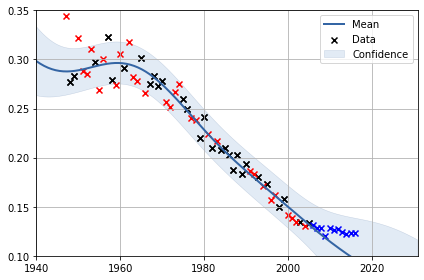

params:[-3.37741188e-03  6.90809948e+00]
validate_rmse: 0.016353879027227736 
 test_rmse: 0.013302274511735589



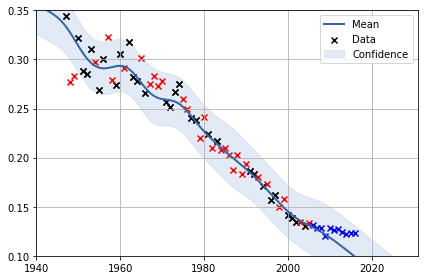

In [17]:
kf = KFold(n_splits=2, random_state=42, shuffle=True)

for train, val in kf.split(x_tv):
    x_train, y_train, x_val, y_val = x_tv[train], y_tv[train], x_tv[val], y_tv[val]
    result = gp_regression(
                         x_train=x_train,y_train=y_train,
                         x_val=x_val,y_val=y_val,
                         x_test=x_test,y_test=y_test,
                         mean_func=poly, init_params=(1,-0.001),
                         kernel = GPy.kern.RBF(1),)

  0%|          | 0/16 [00:00<?, ?it/s]

[('box_cox', 1), ('sa', 1)]
params:[-3.15864162e-02  5.73007513e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.016971949573586734 
 test_rmse: 0.0074944511897968216



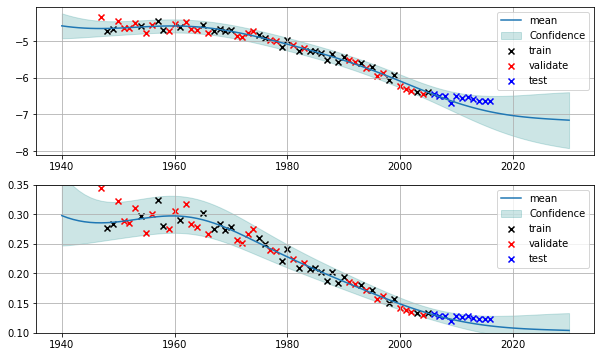

params:[-3.27632380e-02  5.95889701e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01496968282578252 
 test_rmse: 0.005601529175584588



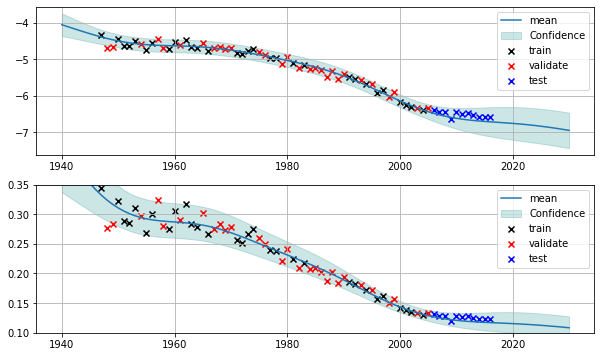

  6%|▋         | 1/16 [00:01<00:17,  1.15s/it]

params:[-7.44006008e-02  1.47687130e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016743062215402067 
 test_rmse: 0.003391300600043844



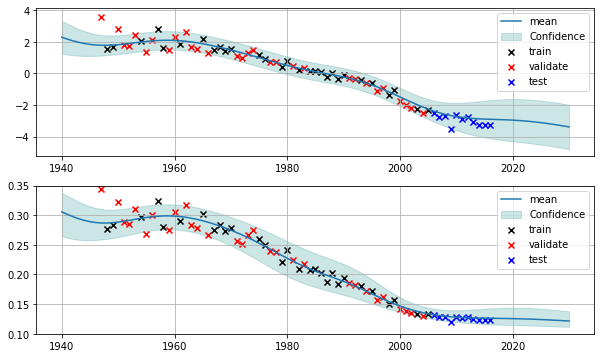

params:[-7.35281286e-02  1.45735937e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016542622573988988 
 test_rmse: 0.006483741038507172



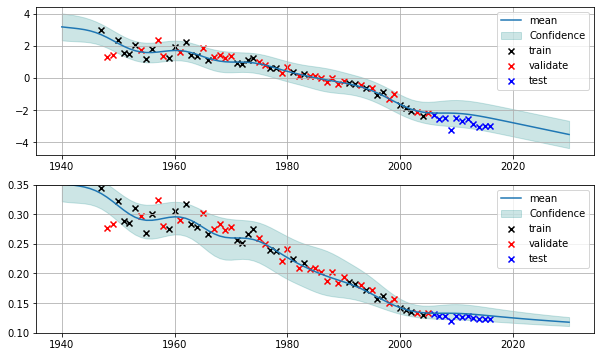

 12%|█▎        | 2/16 [00:02<00:14,  1.06s/it]

params:[-7.77752974e-02  1.53205195e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.016762373592366892 
 test_rmse: 0.0030271019619854457



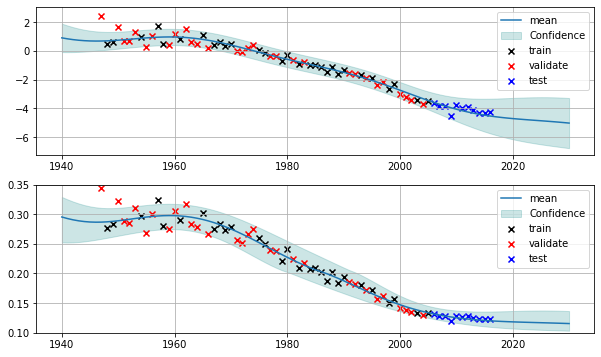

params:[-6.73165424e-02  1.32555790e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.017200004430655804 
 test_rmse: 0.008456903773829827



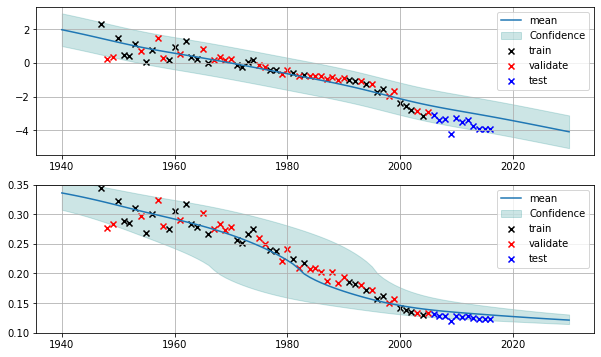

 19%|█▉        | 3/16 [00:03<00:14,  1.08s/it]

params:[-7.40377896e-02  1.46897222e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.016689211304598786 
 test_rmse: 0.0032639606462433884



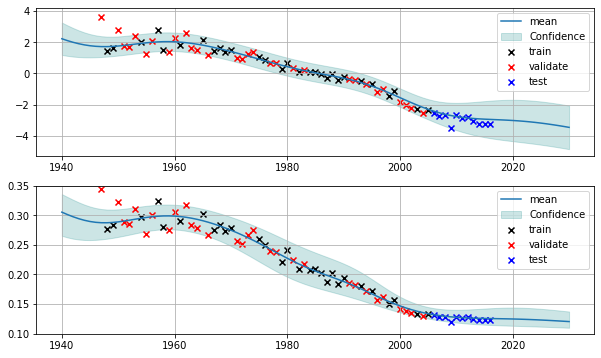

params:[-7.29967720e-02  1.44612798e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.016541648253083855 
 test_rmse: 0.006306745773076863



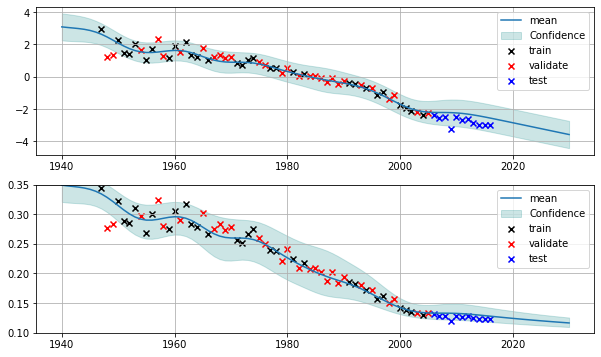

 25%|██▌       | 4/16 [00:04<00:12,  1.03s/it]

params:[-7.99334808e-02  1.56293207e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01663478275273287 
 test_rmse: 0.003578796075388104



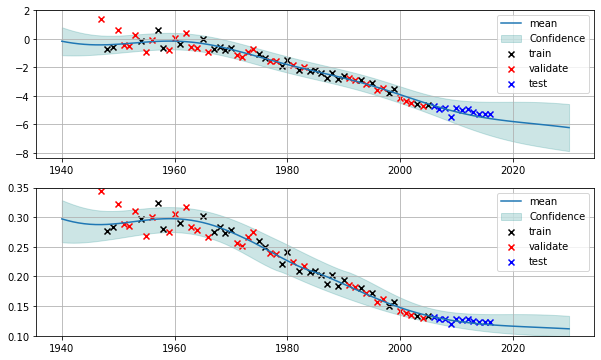

params:[-7.11441714e-02  1.38791650e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.017165731871770947 
 test_rmse: 0.006570992487214076



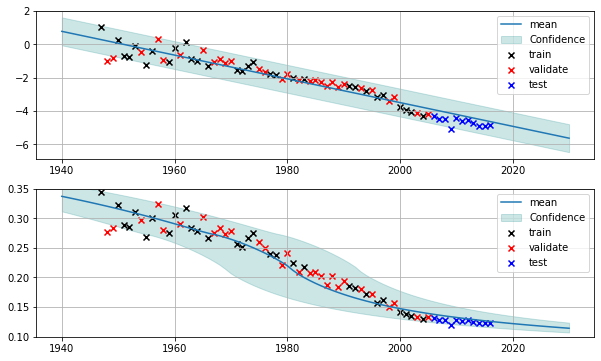

 31%|███▏      | 5/16 [00:05<00:11,  1.01s/it]

params:[-7.48095348e-02  1.47705180e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014778873413101502 
 test_rmse: 0.0077137156908281814



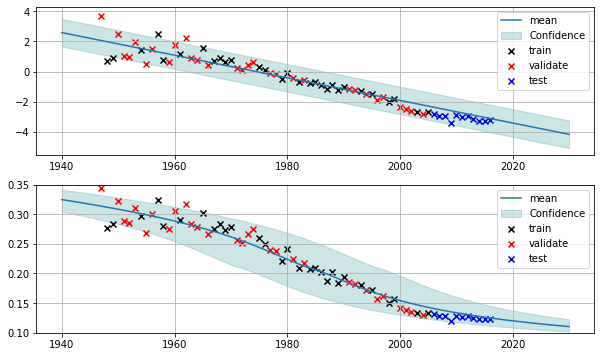

params:[-6.31639995e-02  1.24454133e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.017513143237638678 
 test_rmse: 0.00704421947669016



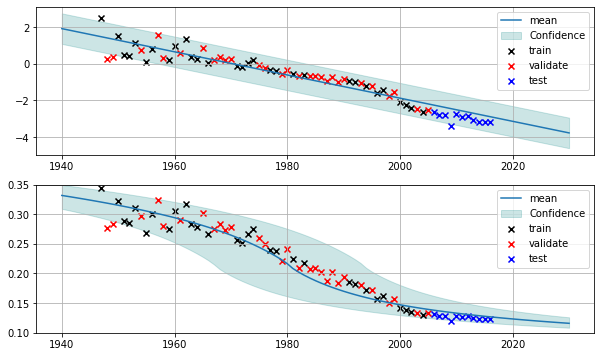

 38%|███▊      | 6/16 [00:06<00:10,  1.01s/it]

params:[-7.90706527e-02  1.55619752e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.016875812313462628 
 test_rmse: 0.01192321015938253



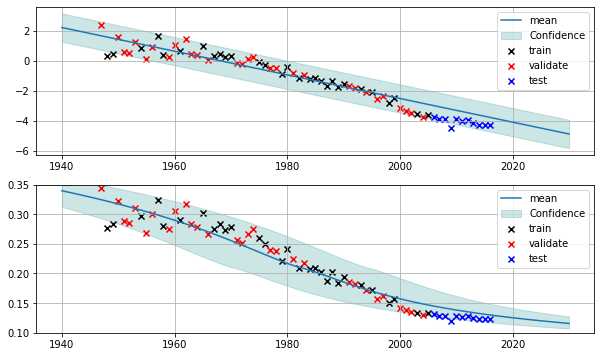

params:[-6.75427302e-02  1.32836780e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.019765694644086028 
 test_rmse: 0.008947170778386996



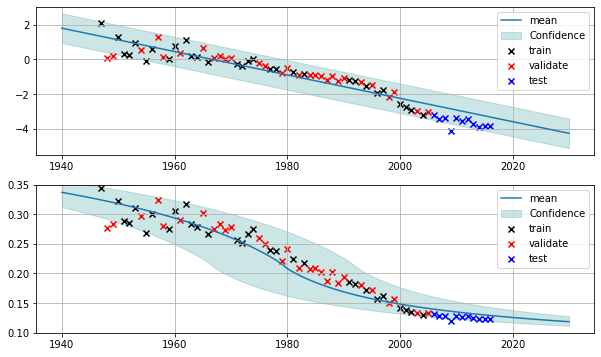

 44%|████▍     | 7/16 [00:07<00:08,  1.03it/s]

params:[-7.33318997e-02  1.45395103e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.015785854042525572 
 test_rmse: 0.013093057498404696



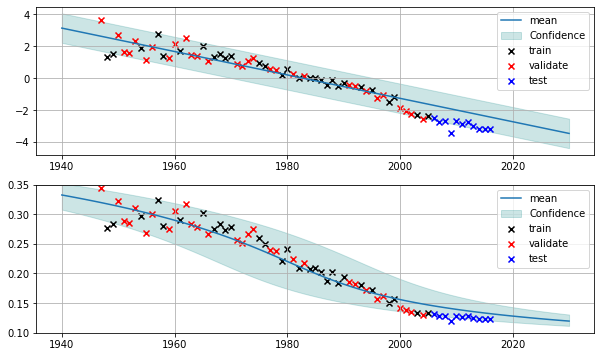

params:[-7.19663996e-02  1.42464993e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.019472139688955267 
 test_rmse: 0.008004961103872277



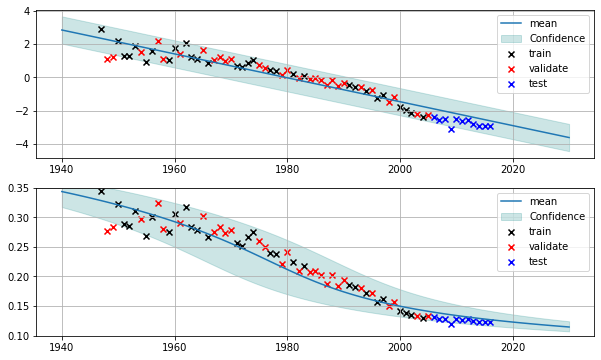

 50%|█████     | 8/16 [00:07<00:07,  1.05it/s]

params:[-7.06565077e-02  1.36659297e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.014643362648698565 
 test_rmse: 0.008915535306357589



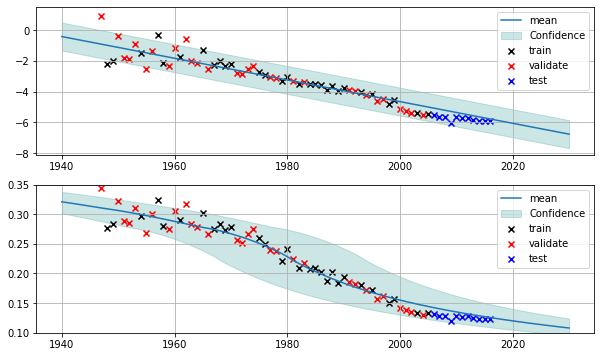

params:[-6.68979181e-02  1.29036752e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.016329458374916065 
 test_rmse: 0.004669460761320605



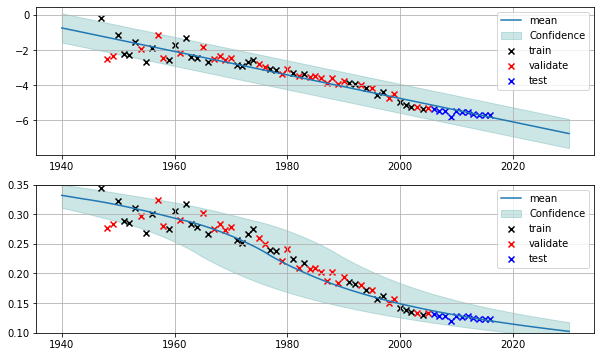

 56%|█████▋    | 9/16 [00:08<00:06,  1.07it/s]

params:[-6.02679182e-02  1.18115408e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014568352226217229 
 test_rmse: 0.008051516754000452



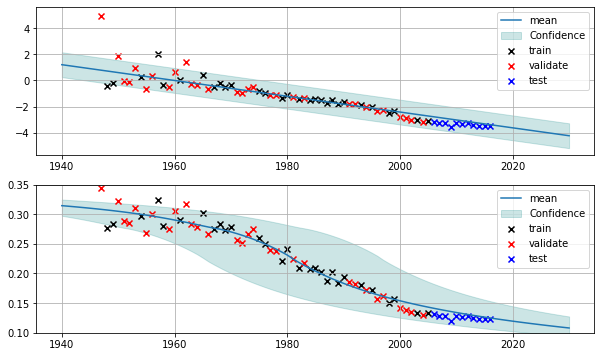

params:[-5.79827727e-02  1.13379755e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016116339257879028 
 test_rmse: 0.0040915619959638015



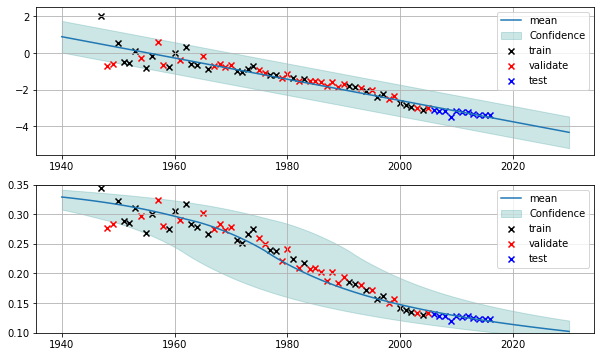

 62%|██████▎   | 10/16 [00:09<00:05,  1.07it/s]

params:[-6.38321416e-02  1.24776527e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015100608932477675 
 test_rmse: 0.011726691718076927



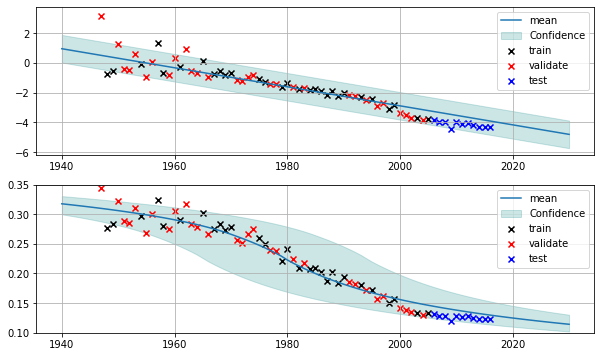

params:[-6.59980312e-02  1.28610518e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015084366507920973 
 test_rmse: 0.004184533628642563



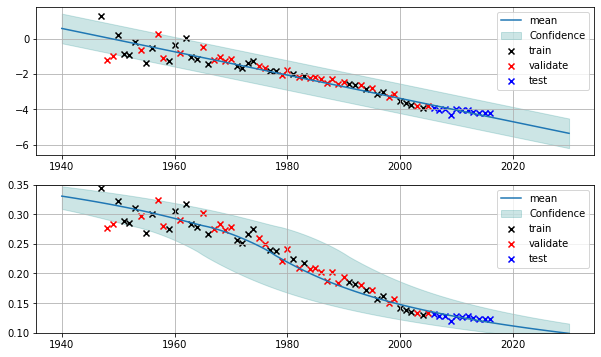

 69%|██████▉   | 11/16 [00:10<00:04,  1.09it/s]

params:[-6.48227385e-02  1.27701393e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014918837280634315 
 test_rmse: 0.010942755157767914



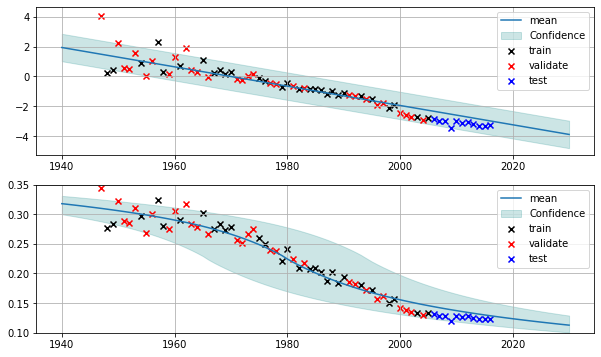

params:[-6.33759285e-02  1.24572017e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01678145982968639 
 test_rmse: 0.004965110424168405



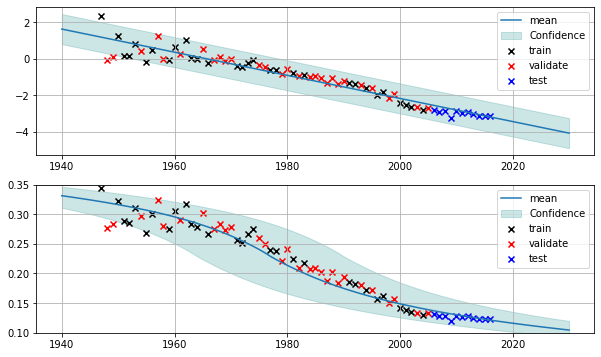

 75%|███████▌  | 12/16 [00:11<00:03,  1.05it/s]

params:[-7.26542912e-02  1.41672337e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.014693901195891491 
 test_rmse: 0.009798613395780488



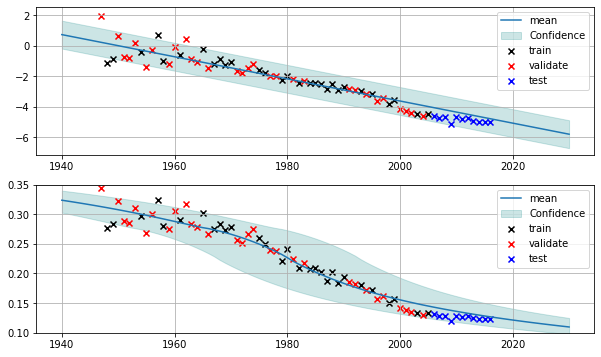

params:[-6.91819734e-02  1.34621663e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.017101490171606486 
 test_rmse: 0.005366503796945821



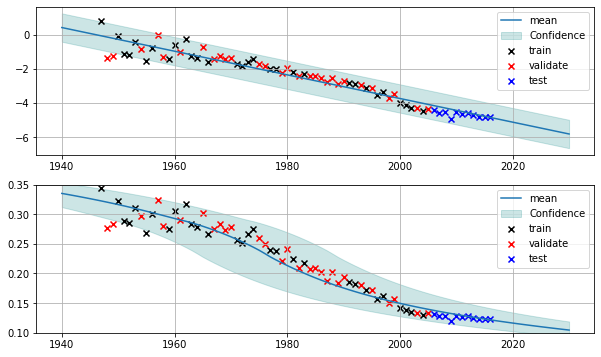

 81%|████████▏ | 13/16 [00:12<00:02,  1.09it/s]

params:[-6.48226951e-02  1.27701307e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014918838818522073 
 test_rmse: 0.010942751600372272



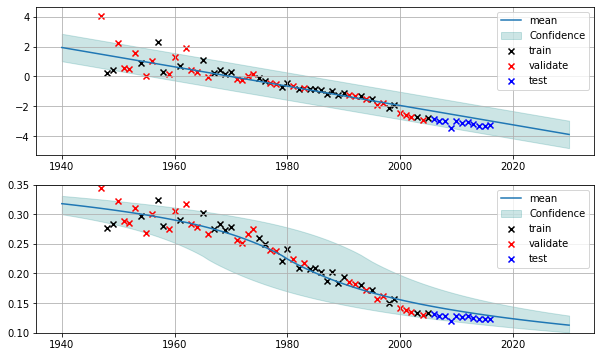

params:[-6.33759022e-02  1.24571962e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.01678147581303887 
 test_rmse: 0.00496512347788866



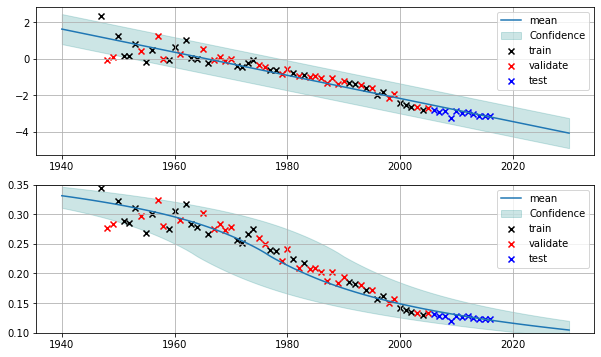

 88%|████████▊ | 14/16 [00:13<00:01,  1.09it/s]

params:[-6.94219390e-02  1.36457705e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015634250234762996 
 test_rmse: 0.013448703733534195



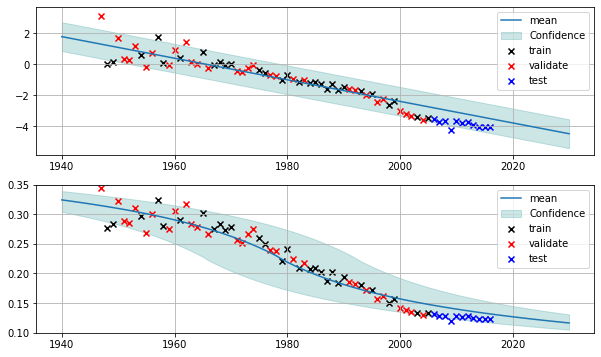

params:[-6.85063524e-02  1.34387414e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.018810232037928504 
 test_rmse: 0.006839945031090986



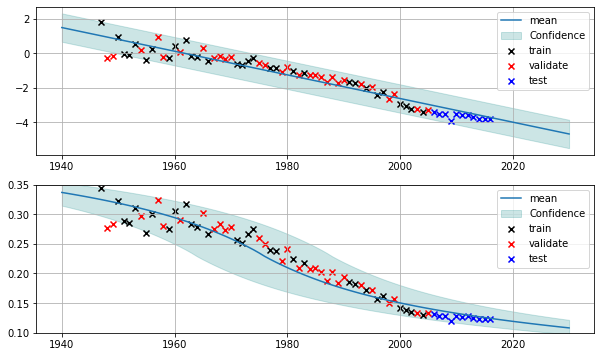

 94%|█████████▍| 15/16 [00:14<00:00,  1.08it/s]

params:[-7.30408892e-02  1.44527907e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.015749197889112516 
 test_rmse: 0.01176943749656517



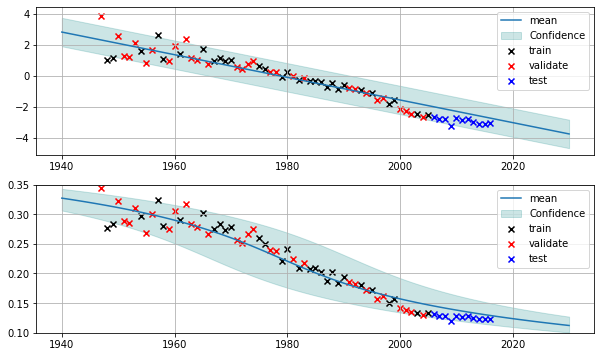

params:[-7.08901899e-02  1.40038886e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.018305779425780225 
 test_rmse: 0.005952885748750425



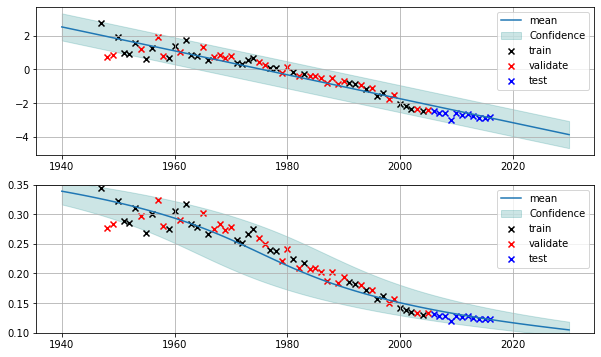

100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


In [16]:
result = grid_search(cwgp_regression, x_tv, y_tv, {"c":4,"n":[1,2],"transformations":["box_cox","sa"]},
                    cv=True, n_splits=2, shuffle=True,
                     x_test=x_test,y_test=y_test,
                     mean_func=poly, init_params=(1,-0.1),
                     kernel = GPy.kern.RBF(1),
                    )